In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Plots
;

In [3]:
const λ = 626e-9
const Γ = 6.4e6 * 2π
const m = @with_unit 57 "u"
const k = 2π / λ
;

In [101]:
# Define the X state Hamiltonian for the N = 0
QN_bounds = (
    S = 1/2, 
    I = 1/2, 
    Λ = 0, 
    N = 1
)
X_state_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

X_state_operator = :(
    BX * Rotation + 
    DX * RotationDistortion + 
    γX * SpinRotation + 
    bFX * Hyperfine_IS + 
    cX * (Hyperfine_Dipolar/3) +
    B_z * Zeeman_z
)

X_state_parameters = QuantumStates.@params begin
    BX = 10023.0841
    DX = 1.154e-2
    γX = 34.7593
    bFX = 2.602
    cX = 2.053
    B_z = 1e-6
end

X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)
evaluate!(X_state_ham)
QuantumStates.solve!(X_state_ham)
;

In [102]:
# Define the A state Hamiltonian for the N = 0...3 rotational states of CaOH
QN_bounds = (
    S = 1/2,
    I = 1/2,
    Λ = (-1,1),
    J = 1/2:5/2
)
A_state_basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

A_state_operator = :(
    T_A * DiagonalOperator +
    Be_A * Rotation + 
    Aso_A * SpinOrbit +
    q_A * ΛDoubling_q +
    p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
)

# Spectroscopic constants for CaOH, A state
A_state_parameters = QuantumStates.@params begin
    T_A = 15998.122 * 299792458 * 1e-4
    Be_A = 0.3412200 * 299792458 * 1e-4
    Aso_A = 66.8181 * 299792458 * 1e-4
    p_A = -0.04287 * 299792458 * 1e-4
    q_A = -0.3257e-3 * 299792458 * 1e-4
end

A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
evaluate!(A_state_ham)
QuantumStates.solve!(A_state_ham)

A_state_J12_pos_parity_states = [A_state_ham.states[5:8];A_state_ham.states[9:16]] # J=1/2 and J=3/2

QN_bounds = (
    S = 1/2, 
    I = 1/2, 
    Λ = (-1,1), 
    N = 0:3
)
A_state_caseB_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)
;

In [103]:
ground_states = X_state_ham.states
excited_states = convert_basis(A_state_J12_pos_parity_states, A_state_caseB_basis)[1:4]

states = [ground_states; excited_states]
n_ground = length(ground_states)
n_excited = length(excited_states)

for state ∈ states
    state.E *= 1e6
end

d_mat = tdms_between_states(states, states)
;

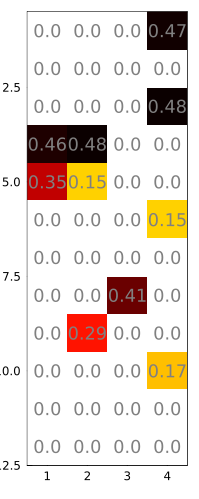

In [104]:
using Plots
tdms = norm.(d_mat[1:n_ground,(n_ground+1):end,1])

heatmap(tdms, c=cgrad(:hot, rev=true), legend=:none)
plot!(
    size=(200,500),
    box=:on,
    grid=true
    )
yflip!(true)

nrow, ncol = size(tdms)
ann = [(j,i, text(round(tdms[i,j], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

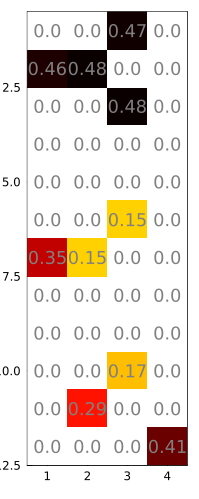

In [105]:
using Plots
tdms = norm.(d_mat[1:n_ground,(n_ground+1):end,3])

heatmap(tdms, c=cgrad(:hot, rev=true), legend=:none)
plot!(
    size=(200,500),
    box=:on,
    grid=true
    )
yflip!(true)

nrow, ncol = size(tdms)
ann = [(j,i, text(round(tdms[i,j], digits=2), 12, :grey, :center)) for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white)

In [106]:
ϕ = π/8

lin_xy = cart2sph * [1,0,0]
linϕ_xy = cart2sph * [cos(ϕ), sin(ϕ), 0]

lin_yz = cart2sph * [0,1,0]
linϕ_yz = cart2sph * [0, cos(ϕ), sin(ϕ)]

lin_zx = cart2sph * [0,0,1]
linϕ_zx = cart2sph * [sin(ϕ), 0, cos(ϕ)]
;

In [165]:
# Laser parameters
Δ1 = +1Γ
Δ2 = +1Γ - 0.1Γ
Δ3 = +1Γ + 0.1Γ
s = 2.0

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(states[end]) - energy(states[3])) + Δ1
ω2 = 2π * (energy(states[end]) - energy(states[10])) + Δ2
ω3 = 2π * (energy(states[end]) - energy(states[10])) + Δ3

ϵ_(ϵ1) = t -> ϵ1
s_func(s) = (r,t) -> s

k̂ = +x̂; ϵ1 = ϵ_(rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω1, s_func(s))
k̂ = -x̂; ϵ2 = ϵ_(rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω1, s_func(s))
k̂ = +ŷ; ϵ3 = ϵ_(rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω1, s_func(s))
k̂ = -ŷ; ϵ4 = ϵ_(rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω1, s_func(s))
k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁻, k̂)); laser5 = Field(k̂, ϵ5, ω1, s_func(s))
k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁻, k̂)); laser6 = Field(k̂, ϵ6, ω1, s_func(s))

lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

k̂ = +x̂; ϵ7 = ϵ_(rotate_pol(σ⁻, k̂)); laser7 = Field(k̂, ϵ7, ω2, s_func(s))
k̂ = -x̂; ϵ8 = ϵ_(rotate_pol(σ⁻, k̂)); laser8 = Field(k̂, ϵ8, ω2, s_func(s))
k̂ = +ŷ; ϵ9 = ϵ_(rotate_pol(σ⁻, k̂)); laser9 = Field(k̂, ϵ9, ω2, s_func(s))
k̂ = -ŷ; ϵ10 = ϵ_(rotate_pol(σ⁻, k̂)); laser10 = Field(k̂, ϵ10, ω2, s_func(s))
k̂ = +ẑ; ϵ11 = ϵ_(rotate_pol(σ⁺, k̂)); laser11 = Field(k̂, ϵ11, ω2, s_func(s))
k̂ = -ẑ; ϵ12 = ϵ_(rotate_pol(σ⁺, k̂)); laser12 = Field(k̂, ϵ12, ω2, s_func(s))

lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

k̂ = +x̂; ϵ13 = ϵ_(rotate_pol(σ⁺, k̂)); laser13 = Field(k̂, ϵ13, ω3, s_func(s))
k̂ = -x̂; ϵ14 = ϵ_(rotate_pol(σ⁺, k̂)); laser14 = Field(k̂, ϵ14, ω3, s_func(s))
k̂ = +ŷ; ϵ15 = ϵ_(rotate_pol(σ⁺, k̂)); laser15 = Field(k̂, ϵ15, ω3, s_func(s))
k̂ = -ŷ; ϵ16 = ϵ_(rotate_pol(σ⁺, k̂)); laser16 = Field(k̂, ϵ16, ω3, s_func(s))
k̂ = +ẑ; ϵ17 = ϵ_(rotate_pol(σ⁻, k̂)); laser17 = Field(k̂, ϵ17, ω3, s_func(s))
k̂ = -ẑ; ϵ18 = ϵ_(rotate_pol(σ⁻, k̂)); laser18 = Field(k̂, ϵ18, ω3, s_func(s))

lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

# k̂ = +x̂; ϵ1 = ϵ_(lin_yz); laser1 = Field(k̂, ϵ1, ω1, s_func(s))
# k̂ = -x̂; ϵ2 = ϵ_(linϕ_yz); laser2 = Field(k̂, ϵ2, ω1, s_func(s))
# k̂ = +ŷ; ϵ3 = ϵ_(lin_zx); laser3 = Field(k̂, ϵ3, ω1, s_func(s))
# k̂ = -ŷ; ϵ4 = ϵ_(linϕ_zx); laser4 = Field(k̂, ϵ4, ω1, s_func(s))
# k̂ = +ẑ; ϵ5 = ϵ_(lin_xy); laser5 = Field(k̂, ϵ5, ω1, s_func(s))
# k̂ = -ẑ; ϵ6 = ϵ_(linϕ_xy); laser6 = Field(k̂, ϵ6, ω1, s_func(s))

lasers = [lasers_1; lasers_2]
# lasers = [lasers_1; lasers_2; lasers_3]
;

In [166]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-1

p = obe(ρ0, particle, states, lasers, d_mat, nothing, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 5p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [170]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.7) .* 2π
prob.p.v = (0., 0., 0.0)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  0.038696 seconds (7.31 k allocations: 26.346 MiB)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -1.2821823983159387e-6
 -2.9084788383532867e-6
 -8.670601819768008

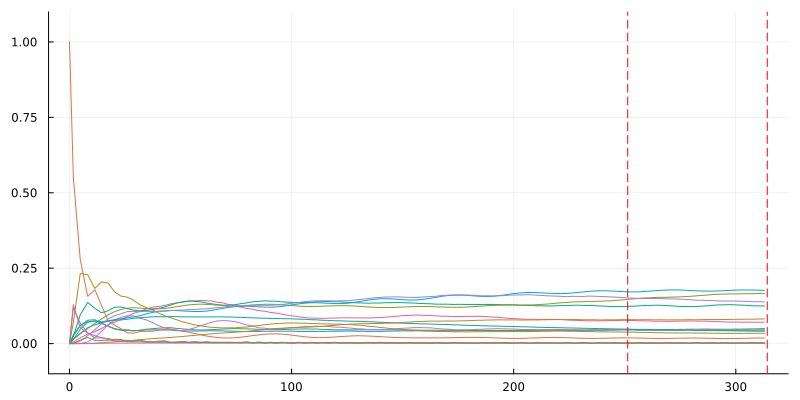

In [171]:
using Plots
plot_us = sol.u[1:10:end]
plot_ts = sol.t[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

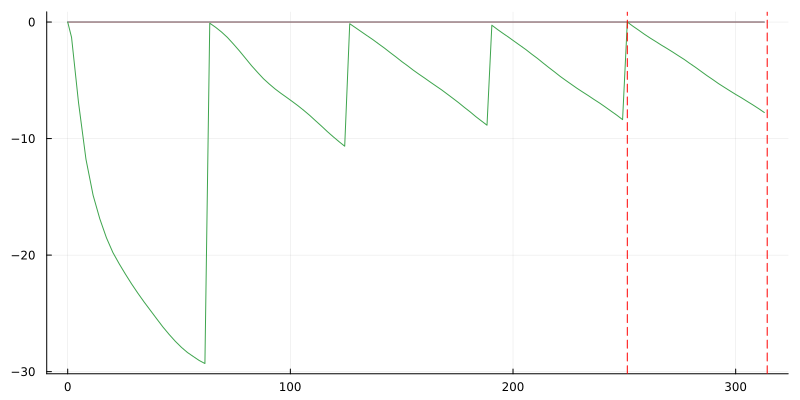

In [172]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [173]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus magnetic field

In [174]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    H = p.extra_p.X_state_ham
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update X state Hamiltonian
    if H.parameters.B_z != scan_params[i].B
    
        H.parameters.B_z = scan_params[i].B
        evaluate!(H)
        QuantumStates.solve!(H)

        for i ∈ eachindex(H.states)
            H.states[i].E *= 1e6
        end
        
        # Update states
        ground_states = H.states
        excited_states = p.extra_p.excited_states
        states = [ground_states; excited_states]

        # Update transition dipole moments
        new_d_mat = tdms_between_states(states, states)

        new_p = obe(p.ρ0, p.particle, states, p.extra_p.lasers, new_d_mat, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    else
        new_p = p
    end
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [185]:
using RectiGrids

freq_res = 1e-1
extra_p = (X_state_ham=X_state_ham, excited_states=excited_states, lasers=lasers)
p = obe(ρ0, particle, states, lasers, d_mat, nothing, true, nothing, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = (0:0.1:1.0)
di = 6
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [186]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


170.265244 seconds (1.63 M allocations: 936.622 MiB)


In [187]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.127527 seconds (77.42 k allocations: 5.264 MiB, 98.46% compilation time)


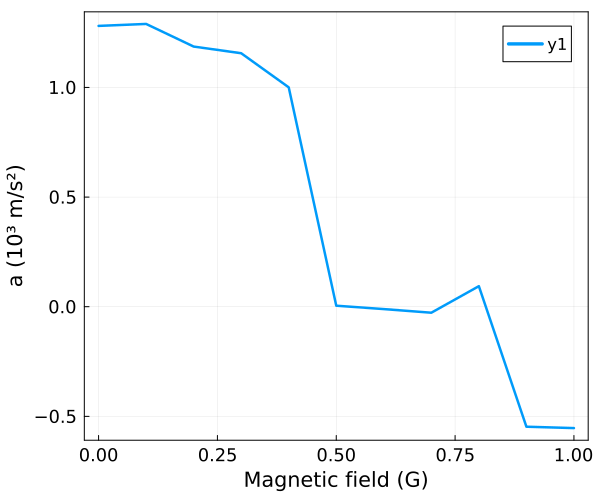

In [188]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,23),
    size=(600,500)
    )

In [189]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.102521 seconds (52.44 k allocations: 4.396 MiB, 98.50% compilation time)


In [190]:
averaged_populations[end]'

16×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.018983444016768297
 0.12502370667935964
 0.05166731764574396
 0.08555955687217838
 0.04205400734177392
 0.045514905391695996
 0.054476707767740815
 0.36378731277835924
 0.07928196005067156
 0.06984895444813848
 0.034766590251467513
 0.016626660582610767
 0.0035064194555018617
 0.0026693142620268164
 0.0026607402684984682
 0.003572402187502262

In [191]:
Γ * sum(averaged_populations[end][9:end])

8.562545649959583e6

## Laser cooling force versus velocity

In [25]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= (scan_params[i].v, 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_params[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (f[1], 0, 0)
end
;

In [26]:
using RectiGrids
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [27]:
freq_res = 1e-1
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 5p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
;

LoadError: UndefVarError: `H` not defined

In [ ]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress:  65%|███████████████████████████              |  ETA: 0:03:48

In [ ]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

In [ ]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-70,22),
    label="DC MOT",
    size=(600,500)
    )

In [ ]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [ ]:
freq_res = 1e-2
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 100
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [ ]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

In [ ]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

In [ ]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-5.5,9),
    size=(700,400)
    )